In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn import metrics
#pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

I have uploaded the dataset in kaggle. You can access the dataset from here 

https://www.kaggle.com/krishnasrujan/frankfurt-stock-exchange


In [2]:
#Frankfurt stock exchange
df=pd.read_csv('C:/Users/Srujan/Documents/Datasets/frankfurt_stock_exchange.csv',parse_dates=['Date'])#,index_col='Date')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   3129 non-null   datetime64[ns]
 1   Open                   2659 non-null   float64       
 2   High                   2992 non-null   float64       
 3   Low                    2992 non-null   float64       
 4   Close                  3129 non-null   float64       
 5   Change                 10 non-null     float64       
 6   Traded Volume          2958 non-null   float64       
 7   Turnover               2946 non-null   float64       
 8   Last Price of the Day  0 non-null      float64       
 9   Daily Traded Units     0 non-null      float64       
 10  Daily Turnover         12 non-null     float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 269.0 KB
None


,Date,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
0,2008-05-09,25.90,29.68,25.90,29.40,NaN,26986.0,791604.0,NaN,NaN,NaN
1,2008-05-12,29.45,29.45,29.00,29.45,NaN,981.0,28612.0,NaN,NaN,NaN
2,2008-05-13,29.50,29.90,29.44,29.85,NaN,1638.0,48289.0,NaN,NaN,NaN
3,2008-05-14,29.30,29.30,28.77,29.30,NaN,183.0,5344.0,NaN,NaN,NaN
4,2008-05-15,29.35,29.70,28.75,29.70,NaN,674.0,19824.0,NaN,NaN,NaN


Dropping uneccessary columns

In [3]:
df.drop(columns=['Change','Last Price of the Day','Daily Traded Units','Daily Turnover','Turnover','Traded Volume'],inplace=True)
df.head()

,Date,Open,High,Low,Close
0,2008-05-09,25.90,29.68,25.90,29.40
1,2008-05-12,29.45,29.45,29.00,29.45
2,2008-05-13,29.50,29.90,29.44,29.85
3,2008-05-14,29.30,29.30,28.77,29.30
4,2008-05-15,29.35,29.70,28.75,29.70


Filling null values by forward fill method

In [4]:
data = df
for i in ['Open','Close','High','Low']:
    data[i] = data[i].ffill()
data

,Date,Open,High,Low,Close
0,2008-05-09,25.90,29.68,25.90,29.40
1,2008-05-12,29.45,29.45,29.00,29.45
2,2008-05-13,29.50,29.90,29.44,29.85
3,2008-05-14,29.30,29.30,28.77,29.30
4,2008-05-15,29.35,29.70,28.75,29.70
...,...,...,...,...,...
3124,2020-08-12,145.00,146.00,143.20,146.00
3125,2020-08-13,145.00,147.60,143.40,147.60
3126,2020-08-14,146.20,148.20,145.00,145.60
3127,2020-08-17,146.20,152.40,145.80,149.60


Creating separate columns for year,month and day. This helps us to check trend and seasonality in the data.

In [5]:
data = data[169:]
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = [d.strftime('%b') for d in data.Date]
data['day'] = pd.DatetimeIndex(data['Date']).dayofweek
data.set_index('Date',inplace=True)

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [6]:
data

,Open,High,Low,Close,year,month,day
Date,,,,,,,
2009-01-01,26.77,26.77,26.10,26.10,2009,Jan,3
2009-01-02,25.91,25.91,25.91,25.91,2009,Jan,4
2009-01-05,25.91,25.91,25.91,25.90,2009,Jan,0
2009-01-06,25.00,26.54,25.00,26.54,2009,Jan,1
2009-01-07,25.62,26.58,25.62,26.58,2009,Jan,2
...,...,...,...,...,...,...,...
2020-08-12,145.00,146.00,143.20,146.00,2020,Aug,2
2020-08-13,145.00,147.60,143.40,147.60,2020,Aug,3
2020-08-14,146.20,148.20,145.00,145.60,2020,Aug,4


If we see the trend and seasonality plots, there is some trend in the data but there is no seasonality
 either in weekdays or in months.

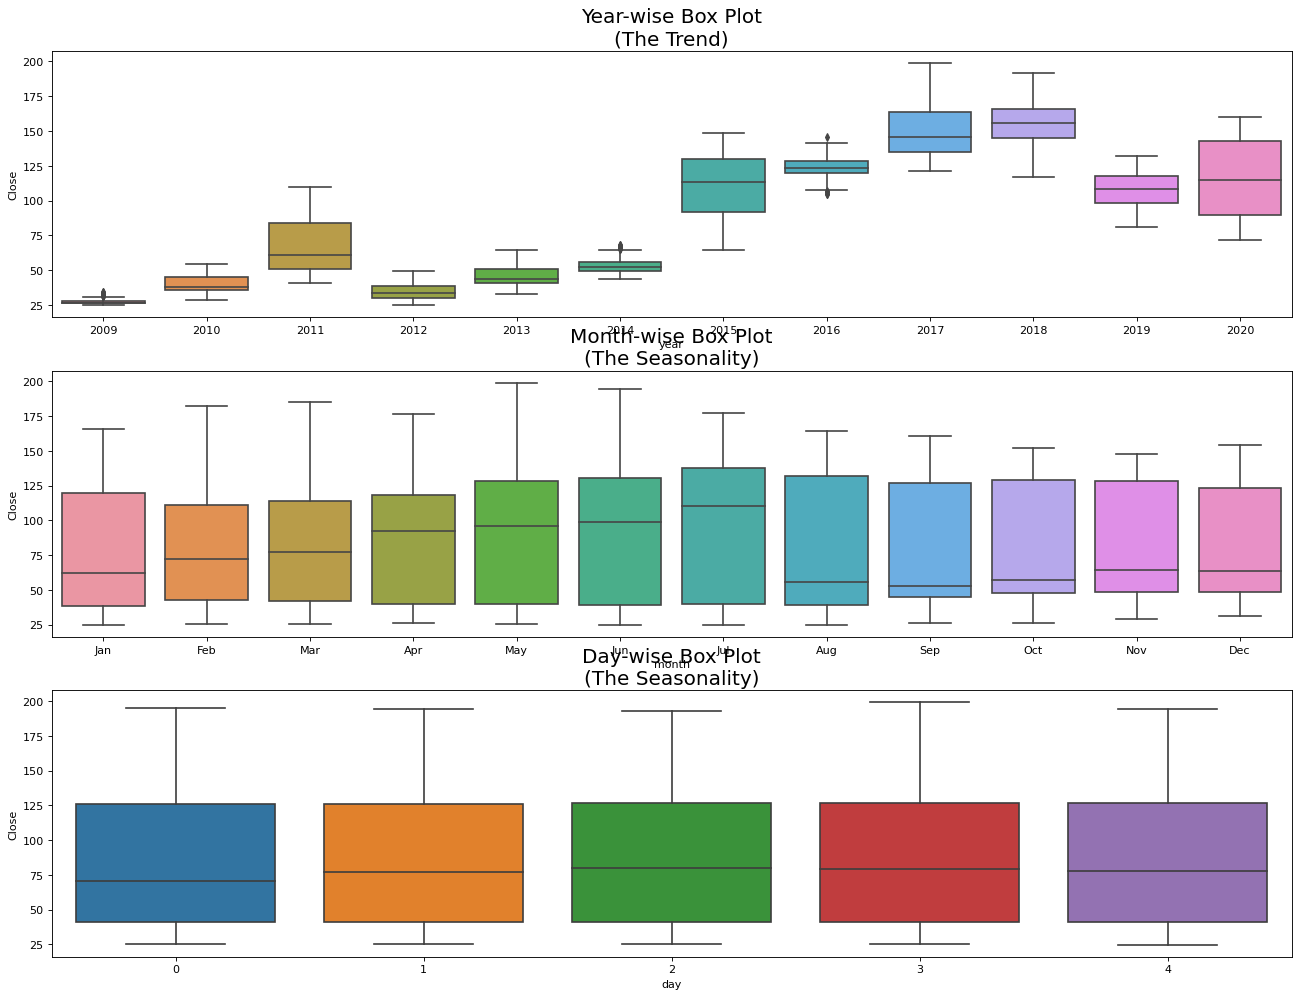

In [7]:
# Draw Plot
fig, axes = plt.subplots(3, 1, figsize=(20,15), dpi= 80)
sns.boxplot(x='year', y='Close', data=data, ax=axes[0])
sns.boxplot(x='month', y='Close', data=data,ax = axes[1])
sns.boxplot(x='day', y='Close', data=data,ax = axes[2])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 

axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

axes[2].set_title('Day-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Let's check the plot of closing price

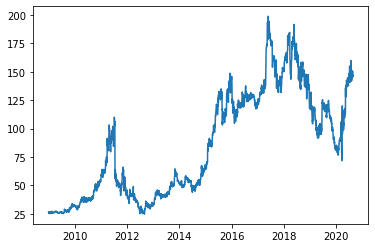

In [8]:
plt.plot(data['Close'])

Performing seasonal decompose. You can see the trend in the data. It is trying to find out seasonality but since there is no seasonality in the data, it is filled with blue color. Also notice that there is no pattern in the residue.

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':


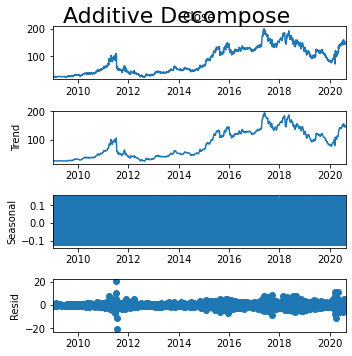

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
# Multiplicative Decomposition 
#result_mul = seasonal_decompose(data['Total_Sunspots'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data['Close'], model='add', extrapolate_trend='freq',freq=5)

# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Detrending the closing price manually.

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Trend')

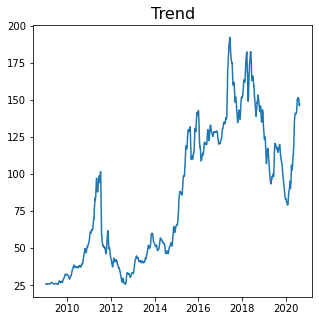

In [10]:
data['rolling_mean'] = data['Close'].rolling(12).mean()
data['Detrend'] = data['Close'] - data['rolling_mean']
plt.plot(data['rolling_mean'])
plt.title('Trend',fontsize=16)

Deseasonalizing the data with seasonal decompose. Since it doesn't have any seasonality, plot doesn't change much.

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


Text(0.5, 1.0, 'Drug Sales deseasonalized by subtracting the seasonal component')

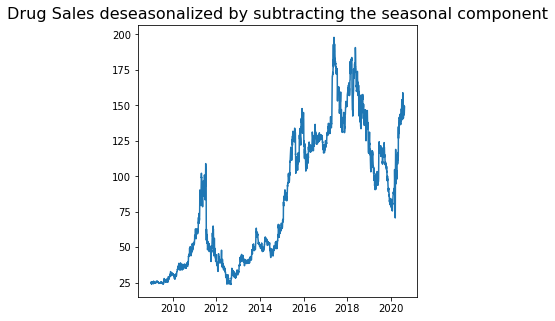

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(data['Close'], model='mul', extrapolate_trend='freq',freq=96)
deseasonalized = data.Close.values -result_add.seasonal
plt.plot(deseasonalized)
plt.title('Drug Sales deseasonalized by subtracting the seasonal component', fontsize=16)

Pandas autocorrelation plot helps to find the dependency of current value on previous values. As there are no patterns in the below plot we cannot get any intuition.

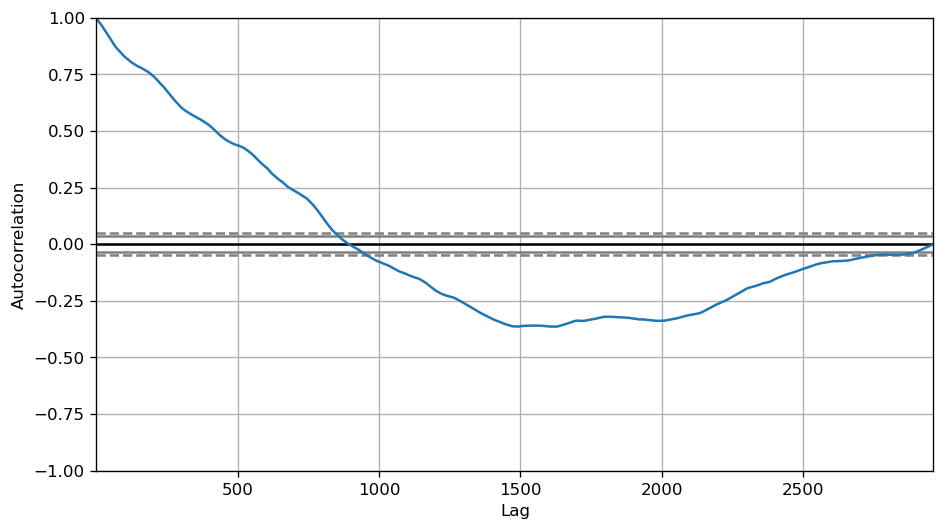

In [12]:
from pandas.plotting import autocorrelation_plot


# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(data['Close'].tolist())

Below plots of autocorrelation and partial autocorrelation play important role in determing the p and q values for ARIMA.

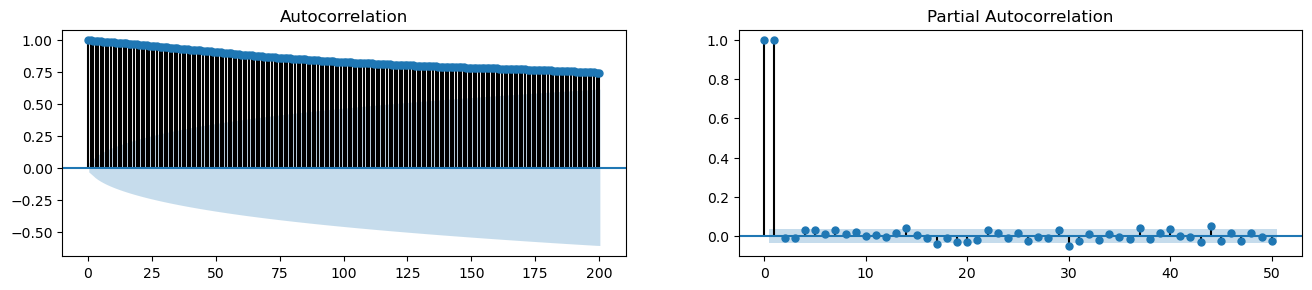

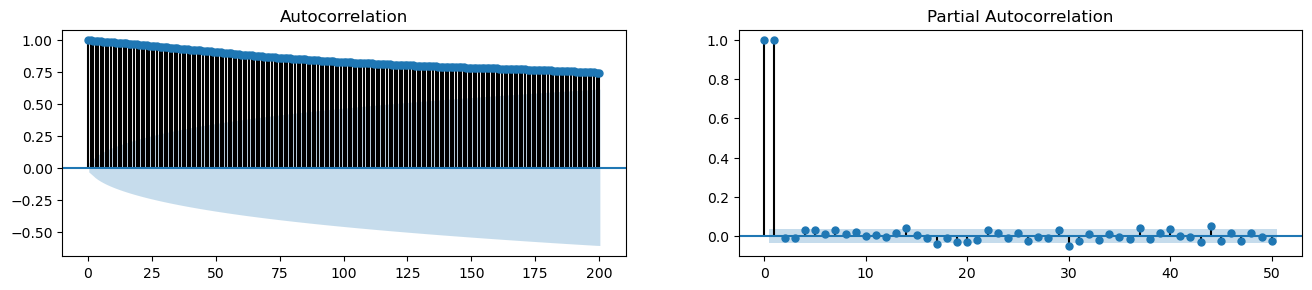

In [13]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['Close'].tolist(), lags=200, ax=axes[0])
plot_pacf(data['Close'].tolist(), lags=50, ax=axes[1])

## Holt Winter's

Holt Winters model doesn't work well on the data. It basically predicts according the the trend. 

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


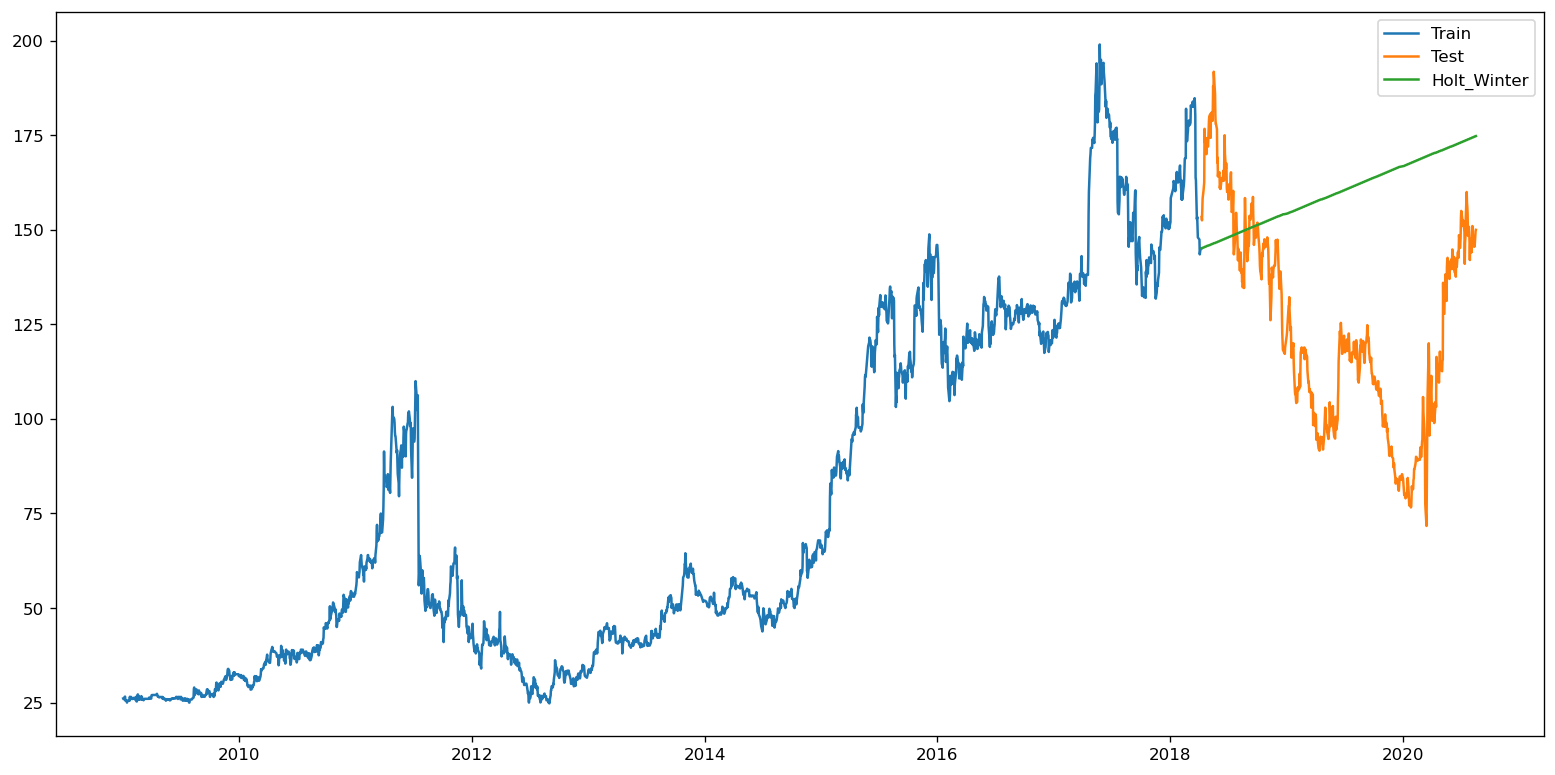

In [14]:
count = int(data.shape[0]*0.8)
Train = data[:count]
Test = data[count:]

y_hat_avg = Test.copy()
fit1 = Holt(np.asarray(Train['Close'])).fit()
y_hat_avg['Holt_Winter'] = fit1.predict(start=count+1,end=data.shape[0])
plt.figure(figsize=(16,8))
plt.plot(Train.index, Train['Close'], label='Train')
plt.plot(Test.index,Test['Close'], label='Test')
plt.plot(y_hat_avg.index,y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')

## ARIMA model

In [15]:
new = data[['Close']]

In [16]:
Train, Test = new.iloc[:count,0], new.iloc[count:,0]
history = [x for x in Train]

We make a list for training data and we will be predicting next day's closing price with this data. Later the predicted value is appended to training data and next day's value is predicted again. This is repeated for all the test data.


ARIMA's forecast function gives 4 outputs.

predicted value

standard error

lower and upper confidance values which are very important when predicting on time series data.


In [17]:
predictions = []
lower_list = []
upper_list = []
for t in range(len(Test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    lower = output[2][0][0]
    upper = output[2][0][1]
    predictions.append(yhat)
    lower_list.append(lower)
    upper_list.append(upper)
    obs = Test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=145.061715, expected=153.400000
predicted=153.637610, expected=152.500000
predicted=152.649722, expected=156.000000
predicted=156.110026, expected=158.300000
predicted=158.458486, expected=160.500000
predicted=160.640044, expected=161.500000
predicted=161.613420, expected=162.500000
predicted=162.593883, expected=176.700000
predicted=177.102503, expected=173.100000
predicted=173.346615, expected=174.300000
predicted=174.313585, expected=171.700000
predicted=171.736572, expected=170.000000
predicted=169.976843, expected=174.100000
predicted=174.199958, expected=173.000000
predicted=173.117747, expected=172.000000
predicted=172.021590, expected=176.800000
predicted=176.923678, expected=179.100000
predicted=179.287852, expected=180.000000
predicted=180.119730, expected=180.600000
predicted=180.689424, expected=174.300000
predicted=174.260170, expected=180.500000
predicted=180.537735, expected=179.700000
predicted=179.865648, expected=181.000000
predicted=181.065431, expected=178

In [18]:
error = metrics.mean_squared_error(Test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 11.893


Below is the plot for orginal test data values, predicted values and confidance interval.

You can see that the predicted values and original values are collinear. 

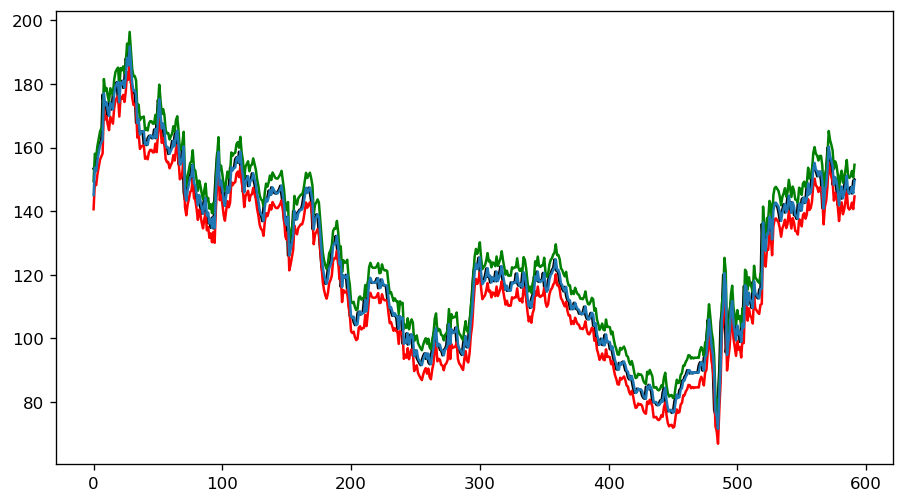

In [19]:
# plot
plt.plot(Test.values,color='black')
plt.plot(lower_list,color='red')
plt.plot(upper_list,color='green')
plt.plot(predictions)
plt.show()

## Random Forest Regressor

In [20]:
data['HL_PCT']=(data['High']-data['Close'])/data['Close']*100
data['PCT_change']=(data['Close']-data['Open'])/data['Open']*100
data.drop(['year','day','rolling_mean','Detrend','Open','High','Low','month'],axis=1,inplace=True)
data

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

,Close,HL_PCT,PCT_change
Date,,,
2009-01-01,26.10,2.567050,-2.502802
2009-01-02,25.91,0.000000,0.000000
2009-01-05,25.90,0.038610,-0.038595
2009-01-06,26.54,0.000000,6.160000
2009-01-07,26.58,0.000000,3.747073
...,...,...,...
2020-08-12,146.00,0.000000,0.689655
2020-08-13,147.60,0.000000,1.793103
2020-08-14,145.60,1.785714,-0.410397


In [21]:
forecast_out=4
data['forecast_col'] = data['Close'].shift(-forecast_out)
data.dropna(inplace=True)
data

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,HL_PCT,PCT_change,forecast_col
Date,,,,
2009-01-01,26.10,2.567050,-2.502802,26.58
2009-01-02,25.91,0.000000,0.000000,25.50
2009-01-05,25.90,0.038610,-0.038595,25.50
2009-01-06,26.54,0.000000,6.160000,25.50
2009-01-07,26.58,0.000000,3.747073,25.00
...,...,...,...,...
2020-08-06,148.00,1.216216,0.543478,146.00
2020-08-07,151.00,0.662252,1.615074,147.60
2020-08-10,146.00,4.520548,-4.325033,145.60


In [22]:
train_count =int(data.shape[0]*0.85)
test_count = data.shape[0]-train_count

In [23]:
y_train = data.iloc[:train_count,3]
y_test  = data.iloc[train_count:,3]
print(y_train.shape,y_test.shape)

(2512,) (444,)


In [24]:
x_train = data.iloc[:train_count,0:-1]
x_test = data.iloc[train_count:,0:-1]

In [25]:
x_lately=x_train[-forecast_out:]
x_train=x_train[:-forecast_out]
df.dropna(inplace=True)
y_train=y_train[:-forecast_out]

In [26]:
print(y_train.shape)

(2508,)


In [27]:
x_train

,Close,HL_PCT,PCT_change
Date,,,
2009-01-01,26.10,2.567050,-2.502802
2009-01-02,25.91,0.000000,0.000000
2009-01-05,25.90,0.038610,-0.038595
2009-01-06,26.54,0.000000,6.160000
2009-01-07,26.58,0.000000,3.747073
...,...,...,...
2018-10-19,144.40,0.623269,-6.111834
2018-10-22,146.50,0.682594,-4.746424
2018-10-23,145.10,1.447278,-5.656697


In [28]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [29]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(x_train,y_train)
y_preds = clf.predict(x_test)
y_lately = clf.predict(x_lately)

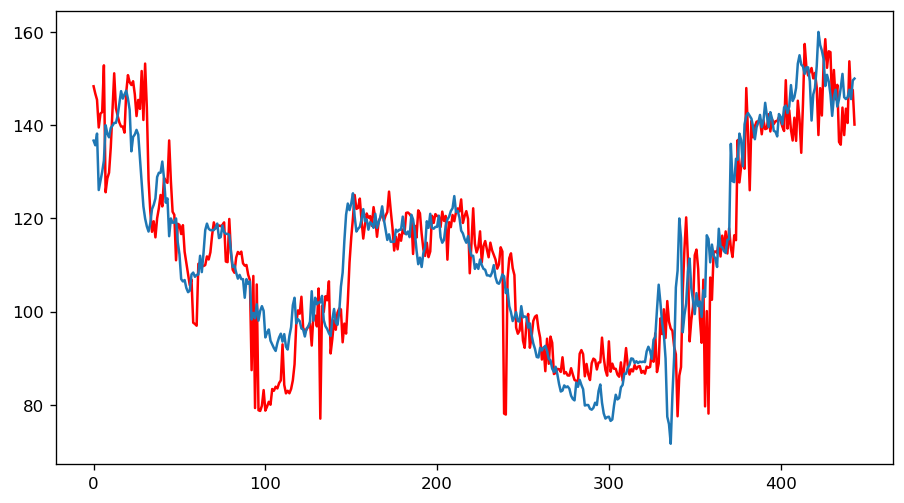

In [30]:
plt.plot(y_preds,color='red')
plt.plot(y_test)
plt.show()

In [31]:
from sklearn import metrics
print(metrics.mean_squared_error(y_preds,y_test))

80.62583721061978


## Ramdom Forest with parameter tuning

In [32]:
clf = RandomForestRegressor(n_estimators = 100,min_samples_leaf = 3,min_samples_split = 8)
clf.fit(x_train,y_train)
y_preds = clf.predict(x_test)
y_lately = clf.predict(x_lately)

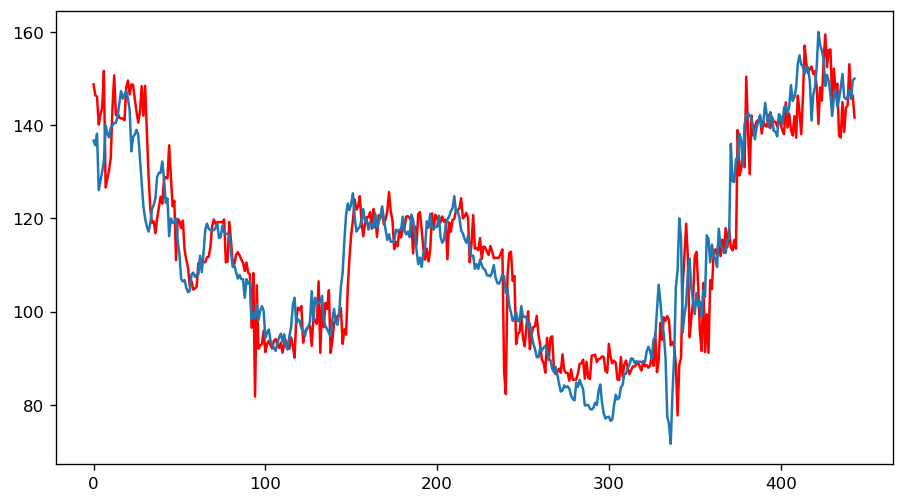

In [33]:
plt.plot(y_preds,color='red')
plt.plot(y_test)
plt.show()

In [34]:
from sklearn import metrics
print(metrics.mean_squared_error(y_preds,y_test))

60.87653136026151
